In [1]:
import numpy as np
import pandas as pd #to read files or work with dataframes
import yfinance as yf
import datetime as datetime #to specify start and end dates
import matplotlib.pyplot as plt #to visualize
from matplotlib import style
import pandas_datareader as dr #to collect data
from pandas_datareader import data
import cvxpy as cp
import cvxopt as opt
from cvxopt import blas, solvers
import scipy.optimize as sco

%matplotlib inline

In [2]:
#Parameter set up:
n_portfolios = 5000
n_days = 252
assets = ['BARC.L', 'GSK.L', 'BP.L', 'BATS.L', 'AVV.L']
start_date = '2020-01-01'
end_date = '2022-04-25'

n_assets = len(assets)

In [3]:
#Downloading stockprices from Yahoo Finance:
prices = yf.download(assets, start=start_date, end=end_date, adjusted=True)

[*********************100%***********************]  5 of 5 completed


In [4]:
#Calculation of Annualised Average Returns and the corresponding Standard Deviation:
returns = prices['Adj Close'].pct_change().dropna()
returns

,AVV.L,BARC.L,BATS.L,BP.L,GSK.L
Date,,,,,
2020-01-03,-0.004243,-0.010259,0.026646,0.027451,0.004051
2020-01-06,-0.003835,-0.012657,-0.000597,0.020342,-0.007846
2020-01-07,0.010265,0.011935,0.016716,-0.010514,-0.004519
2020-01-08,0.006774,-0.006006,0.018644,-0.009022,0.004993
2020-01-09,0.006645,0.004505,-0.003026,-0.004552,0.010727
...,...,...,...,...,...
2022-04-14,-0.010242,0.011091,-0.000460,0.005285,-0.004604
2022-04-19,0.002070,-0.001097,0.004598,0.004005,-0.007558
2022-04-20,0.015696,0.021826,0.011291,0.000249,-0.010684


In [5]:
avg_returns = returns.mean()* n_days
avg_returns

AVV.L    -0.083242
BARC.L    0.041712
BATS.L    0.120962
BP.L      0.075509
GSK.L     0.070394
dtype: float64

In [6]:
cov_mat = returns.cov() * n_days
cov_mat

,AVV.L,BARC.L,BATS.L,BP.L,GSK.L
AVV.L,0.161465,0.060001,0.025978,0.051459,0.029991
BARC.L,0.060001,0.218743,0.050455,0.134251,0.030951
BATS.L,0.025978,0.050455,0.074709,0.056675,0.030999
BP.L,0.051459,0.134251,0.056675,0.207837,0.037386
GSK.L,0.029991,0.030951,0.030999,0.037386,0.053178


In [7]:
prices = pd.DataFrame()
for tick in assets:
    prices[tick] = data.DataReader(tick, data_source='yahoo', start='2020-01-01', end='2022-04-25')['Adj Close']
prices.columns = assets
    
prices

,BARC.L,GSK.L,BP.L,BATS.L,AVV.L
Date,,,,,
2020-01-02,171.548996,1574.029663,414.027344,2752.842529,3688.335205
2020-01-03,169.789062,1580.406616,425.392853,2826.195557,3672.687012
2020-01-06,167.640045,1568.006836,434.046234,2824.509277,3658.603516
2020-01-07,169.640854,1560.921265,429.482758,2871.724854,3696.159912
2020-01-08,168.621918,1568.715454,425.608185,2925.264160,3721.197266
...,...,...,...,...,...
2022-04-19,145.699997,1759.599976,395.835083,3277.000000,2421.000000
2022-04-20,148.880005,1740.800049,395.933807,3314.000000,2459.000000
2022-04-21,150.059998,1744.800049,397.907776,3344.500000,2521.000000


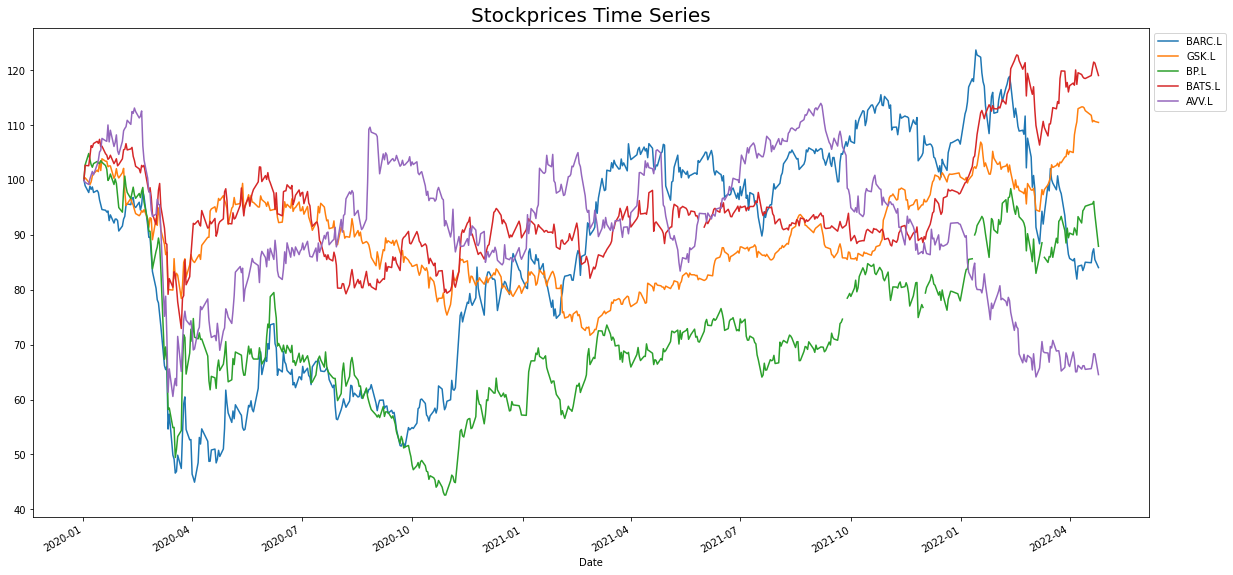

In [8]:
# Plotting the timeseries:
timeseries = prices / prices.iloc[0] * 100
timeseries.plot(figsize=(20, 10))
plt.title('Stockprices Time Series', fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

In [9]:
#Simulation of random portfolio weights:
np.random.seed(42)
weights = np.random.random(size=(n_portfolios, n_assets))
weights /= np.sum(weights, axis=1) [:, np.newaxis]
weights

array([[0.13319703, 0.33810082, 0.26031769, 0.21289984, 0.05548463],
       [0.06528492, 0.02430844, 0.36250145, 0.25157131, 0.29633388],
       [0.00928442, 0.43746759, 0.37546445, 0.09577331, 0.08201023],
       ...,
       [0.22243423, 0.19584991, 0.10593145, 0.22811743, 0.24766699],
       [0.28174359, 0.11280551, 0.48060119, 0.09943755, 0.02541216],
       [0.09181403, 0.20381177, 0.25884847, 0.17866895, 0.26685678]])

In [10]:
portf_returns = np.dot(weights, avg_returns)

portf_vol = np.diag(np.sqrt(np.dot(weights, np.dot(cov_mat, weights.T))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_returns / portf_vol

In [11]:
portf_results = pd.DataFrame({'returns': portf_returns,
                             'volatility': portf_vol,
                             'sharpe_ratio': portf_sharpe_ratio})
portf_results

,returns,volatility,sharpe_ratio
0,0.054485,0.300856,0.181101
1,0.079284,0.241406,0.328427
2,0.075897,0.303473,0.250094
3,0.065693,0.266569,0.246439
4,0.026793,0.253665,0.105622
...,...,...,...
4995,0.076055,0.249091,0.305330
4996,0.044817,0.258033,0.173686
4997,0.037126,0.268245,0.138404
4998,0.048684,0.253241,0.192244


In [12]:
n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_returns_ef = np.linspace(portf_results.returns.min(),
                               portf_results.returns.max(),
                               n_points)
portf_rerturns_ef = np.round(portf_returns_ef, 2)
portf_returns = np.round(portf_returns, 2)

for point_index in range (n_points):
    if portf_returns_ef[point_index] not in portf_returns:
       indices_to_skip.append(point_index)
       continue
    matched_ind = np.where(portf_returns ==
                           portf_returns_ef[point_index])
    
portf_returns_ef = np.delete(portf_returns_ef, indices_to_skip)

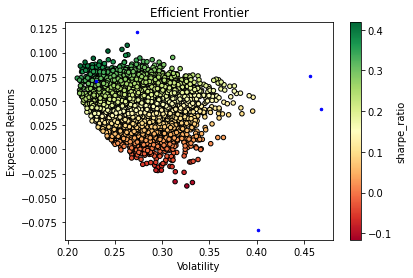

In [13]:
marks = ['.', '.', '.', '.', '.']


fig, ax = plt.subplots()
portf_results.plot(kind='scatter', 
                   x='volatility', 
                   y='returns', 
                   c='sharpe_ratio', 
                   cmap='RdYlGn', 
                   edgecolors='black', 
                   ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_returns_ef, 'b--', linewidth = 3)
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
               y=avg_returns[asset_index],
               marker=marks[asset_index],
               s=25,
               color='blue',
               label=())

In [14]:
max_sharpe_ind = np.argmax(portf_results.sharpe_ratio)
max_sharpe_portf = portf_results.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results.volatility)
min_vol_portf = portf_results.loc[min_vol_ind]

In [15]:
print ('Maximum Sharpe Ratio portfolio ----')
print ('Performance')
for index, value in max_sharpe_portf.items() :
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets,
weights[np.argmax(portf_results.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 10.15% volatility: 24.27% sharpe_ratio: 41.82% 
Weights
BARC.L: 0.98% GSK.L: 10.79% BP.L: 70.58% BATS.L: 0.54% AVV.L: 17.11% 

In [16]:
print ('Minimum Volatility portfolio ----')
print ('Performance')
for index, value in min_vol_portf.items() :
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets,
weights[np.argmin(portf_results.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 7.35% volatility: 21.03% sharpe_ratio: 34.98% 
Weights
BARC.L: 70.79% GSK.L: 7.00% BP.L: 4.00% BATS.L: 9.80% AVV.L: 8.41% 

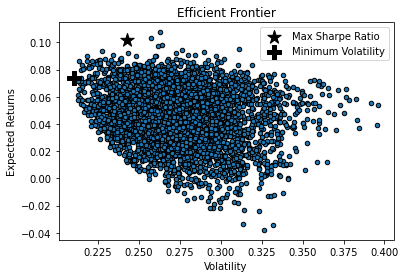

In [17]:
fig, ax = plt.subplots()
portf_results.plot(kind='scatter',
                   x='volatility',
                   y='returns',
                   cmap='RdYlGn',
                   edgecolors='black',
                   ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
           y=max_sharpe_portf.returns,
           c='black',
           marker='*',
           s=200,
           label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
           y=min_vol_portf.returns,
           c='black',
           marker='P',
           s=200,
           label='Minimum Volatility')
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')
ax.legend()

In [18]:
# Define functions for calculating portfolio return and volatility:

def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [19]:
# Define the function calculating theEfficient Frontier:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range (n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq',
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol,
                                           initial_guess,
                                           args=args,
                                           method='SLSQP',
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

In [20]:
# Define the considered range of returns
rtns_range = np.linspace (0.1, 0.32, 200)

In [21]:
# Calculate the Efficient Frontier
efficient_portfolios = get_efficient_frontier(avg_returns,
                                              cov_mat,
                                              rtns_range)

In [22]:
# Extract the volatilities of the efficient portfolios:
vols_range = [x['fun'] for x in efficient_portfolios]

[Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 Text(0.5, 1.0, 'Efficient Frontier')]

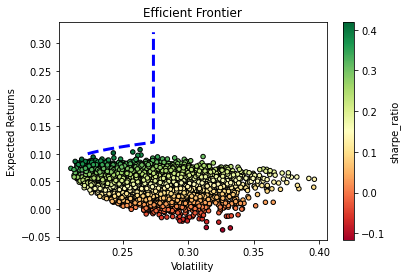

In [23]:
# Plot the calculated Efficient Frontier, together with the simulated portfolios:
fig, ax = plt.subplots()
portf_results.plot(kind='scatter',
                   x='volatility',
                   y='returns',
                   c='sharpe_ratio',
                   cmap='RdYlGn',
                   edgecolors='black',
                   ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')

In [24]:
# Identify the minimum volatility portfolio:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Voltatility': min_vol_portf_rtn,
                 'Sharpe Ratio': (min_vol_portf_rtn /
                                  min_vol_portf_vol)}

In [25]:
# Print the performance summary:
print ('Minimum volatility portfolio ----')
print ('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
    
print('\nWeights')
for x, y in zip (assets,
efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum volatility portfolio ----
Performance
Return: 10.00% Voltatility: 10.00% Sharpe Ratio: 44.81% 
Weights
BARC.L: 0.00% GSK.L: 0.00% BP.L: 58.55% BATS.L: 0.00% AVV.L: 41.45% 

In [26]:
# Define the objective function for the negative Sharpe Ratio:

def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate) :
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

In [27]:
# Finding the optimized portfolio:
n_assets = len(avg_returns)
rf_rate = 0.01

args = (avg_returns, cov_mat, rf_rate)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range (n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=initial_guess,
                                args=args,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

In [28]:
# Extracting information about the maximu Sharpe Ratio portfolio:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                            avg_returns,
                                            cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

In [29]:
# Printing performance summary:
print ('Maximum Sharpe Ratio portfolio ----')
print ('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100*value:.2f}% ', end="", flush=True)
    
print('\nWeights')
for x, y in zip (assets, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 11.03% Volatility: 24.33% Sharpe Ratio: 41.22% 
Weights
BARC.L: 0.00% GSK.L: 0.00% BP.L: 78.88% BATS.L: 0.00% AVV.L: 21.12% 

In [30]:
# Convert the annualised average returns and the covariance matrix to numpy arrays:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

In [31]:
# Set up the optimization problem
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function,
                     [cp.sum(weights) == 1, weights>= 0])

In [32]:
# Calculate the Efficient Frontier
n_points = 20
portf_rtn_cvx_ef = np.zeros(n_points)
portf_vol_cvx_ef = np.zeros(n_points)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=n_points)

for i in range (n_points) :
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

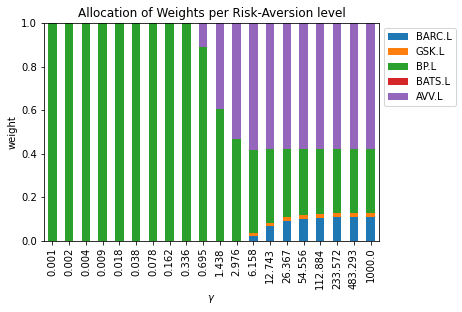

In [33]:
# Plot the allocation for different values of the risk-aversion parameter
weights_df = pd.DataFrame(weights_ef,
                          columns=assets,
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True)
ax.set(title='Allocation of Weights per Risk-Aversion level',
       xlabel=r'$\gamma$',
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

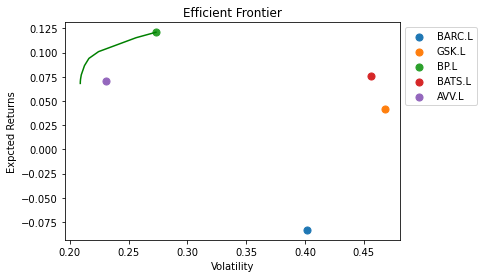

In [34]:
# Plotting the Efficient Frontier with individual assets
MARKS = ['.', '.', '.', '.', '.', '.']

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]),
                 y=avg_returns[asset_index],
                 marker=MARKS[asset_index],
                 label=assets[asset_index],
                 s=200)
ax.set(title='Efficient Frontier',
       xlabel='Volatility',
       ylabel='Expcted Returns', )
ax.legend(bbox_to_anchor=(1,1))

[Text(0.5, 1.0, 'Maximized Risk-Adjusted Retrun'),
 Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 (0.1, 0.5),
 (0.1, 0.75)]

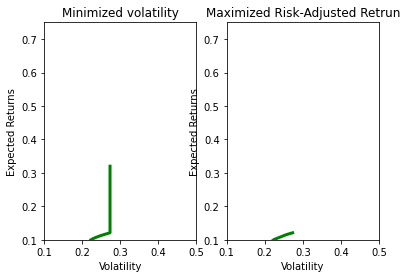

In [35]:
# Efficient frontier comparison
x_lim = [0.1, 0.5]
y_lim = [0.1, 0.75]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, 'g-', linewidth=3)
ax[0].set(title='Minimized volatility',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-', linewidth=3)
ax[1].set(title='Maximized Risk-Adjusted Retrun',
          xlabel='Volatility',
          ylabel='Expected Returns',
          xlim=x_lim,
          ylim=y_lim)

In [36]:
# Analysing maximum allowable leverage
max_leverage= cp.Parameter()
problem_with_leverage = cp.Problem(objective_function,
                                   [cp.sum(weights) == 1,
                                    cp.norm(weights, 1) <= max_leverage])

In [37]:
# Redefining objects in order to store the results to be either larger 2D matrices or 3 = [1, 2, 5]
leverage_range = [1, 3, 5]
len_leverage = len(leverage_range)
n_points = 20

portf_vol_l_ef = np.zeros((n_points, len_leverage))
portf_rtn_l_ef = np.zeros((n_points, len_leverage))
weights_ef =np.zeros((len_leverage, n_points, n_assets))

for lev_ind, leverage in enumerate(leverage_range) :
    for gamma_ind in range(n_points):
        max_leverage.value = leverage
        gamma.value = gamma_range[gamma_ind]
        problem_with_leverage.solve(verbose=True)
        portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) May 12 05:50:23 AM: Your problem has 5 variables, 2 constraints, and 2 parameters.
(CVXPY) May 12 05:50:23 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 05:50:23 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 12 05:50:23 AM: Compiling problem (target solver=OSQP).
(CVXPY) May 12 05:50:23 AM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) May 12 05:50:23 AM: Applying reduction FlipObjective
(CVXPY) May 12 05:50:23 AM: Applying reduction

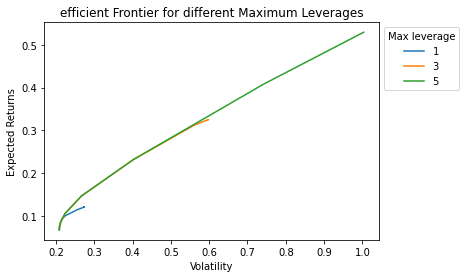

In [38]:
# Efficient frontiers for dfferent maximum leverages
fig, ax=plt.subplots()

for leverage_index, leverage in enumerate(leverage_range):
    plt.plot(portf_vol_l_ef[:, leverage_index],
            portf_rtn_l_ef[:, leverage_index],
            label=f'{leverage}')
    
ax.set(title='efficient Frontier for different Maximum Leverages',
       xlabel='Volatility',
       ylabel='Expected Returns')
ax.legend(title='Max leverage',
          bbox_to_anchor=(1,1))

Text(0.5, 1.0, 'Weights allocation per risk-aversion level')

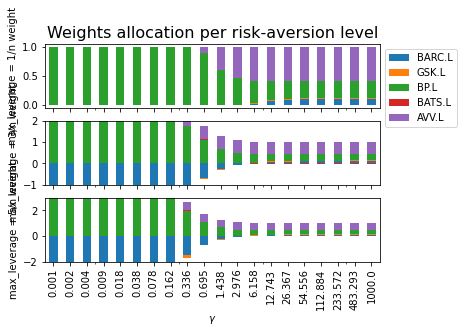

In [39]:
# Plotting weight allocation per varying risk-aversion levels
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame (weights_ef[ax_index],
                               columns=assets,
                               index=np.round(gamma_range, 3))
    weights_df.plot(kind='bar',
                    stacked=True,
                    ax=ax[ax_index],
                    legend=None)
    ax[ax_index].set(ylabel=(f'max_leverage = {leverage_range[ax_index]}'
                             '/n weight'))
    
ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1))
ax[0].set_title('Weights allocation per risk-aversion level',
                fontsize=16)